## Explore and Calculate Metrics

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
#binary_dirs = 'binaries_model1_tfrecordz/'
#binary_dirs = 'binaries_model2_tfrecordz/'
#binary_dirs = 'binaries_model3_tfrecordz/'
#binary_dirs = 'binaries_model4_tfrecordz/'
#binary_dirs = 'binaries_model10_tfrecordz/'
#binary_dirs = 'binaries_model5_tfrecordz/'
binary_dirs = 'binaries_model6_tfrecordz/'

# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
#any extra tag to anything
adder_dats = ''
# which iou's to save?
#ioustar = [0.9,0.95] # fig, caption
ioustar = [0.9] # fig, caption
scorestar = 0.1

adder = ''
#adder = 'colorbar'
#adder = 'truebox'

How do we want to quantify how well we are doing?

In [2]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

In [3]:
import pickle
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [4]:
# # debugging
# import metric_utils
# reload(metric_utils)
# from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [5]:
# build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += adder
pp += '.pickle'
with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)

Final box analytics:

In [6]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)

In [7]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [8]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


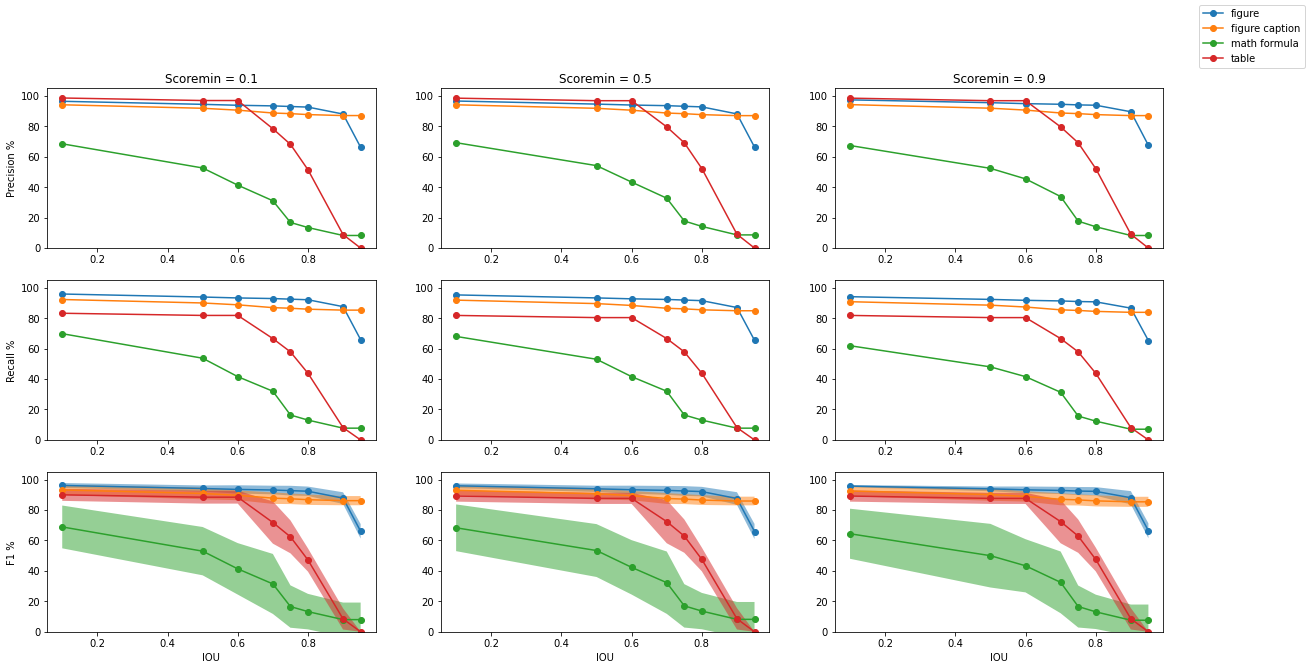

In [9]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [10]:
scoremin = 0.1

What IOU cut-offs for each label? for reference:

In [11]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [12]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.6] # fig, fig+caption, math formula, table

In [13]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [14]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [15]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.6            
# of objs       507             489             73              61             
--------------------------------------------------------------------------------------------
TP              87.6%           85.3%           19.2%           83.6%          
FP              11.8%           12.7%           78.1%           3.3%           
FN              12.4%           14.7%           80.8%           16.4%          
--------------------------------------------------------------------------------------------
Precision       88.2+/-3.2%     87.1+/-2.4%     18.5+/-10.1%    96.5+/-4.3%    
Recall          87.6+/-1.9%     85.3+/-3.0%     16.5+/-8.4%     86.2+/-12.8%   
F1              87.9+/-2.3%     86.1+/-2.5%     17.4+/-9.1%     90.4+/-7.9%    


In [16]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
                                              truebox3,boxes_sq5,labels_sq5, 
                                              scores_sq5,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               [0.8,0.8,0.8,0.8])
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, [0.8,0.8,0.8,0.8])

SCORE =  0.1  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       507             489             73              61             
--------------------------------------------------------------------------------------------
TP              92.1%           85.9%           19.2%           45.9%          
FP              7.3%            12.1%           78.1%           41.0%          
FN              7.9%            14.1%           80.8%           54.1%          
--------------------------------------------------------------------------------------------
Precision       92.8+/-2.8%     87.8+/-1.8%     19.3+/-3.9%     54.2+/-9.2%    
Recall          92.2+/-2.6%     86.0+/-2.6%     20.3+/-8.5%     46.4+/-8.7%    
F1              92.5+/-2.4%     86.8+/-1.9%     19.5+/-5.8%     49.7+/-7.9%    


## Vs. Time
Also, let's plot metrics vs. year.

In [17]:
# pick a min score and a min IOU
scoremin = 0.1
ioumin = 0.8

In [18]:
df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       truebox3,boxes_sq5,labels_sq5,scores_sq5)

In [19]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1895-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1897-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1900-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1901-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1904-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
sampleHist = '10Y' # 5 years

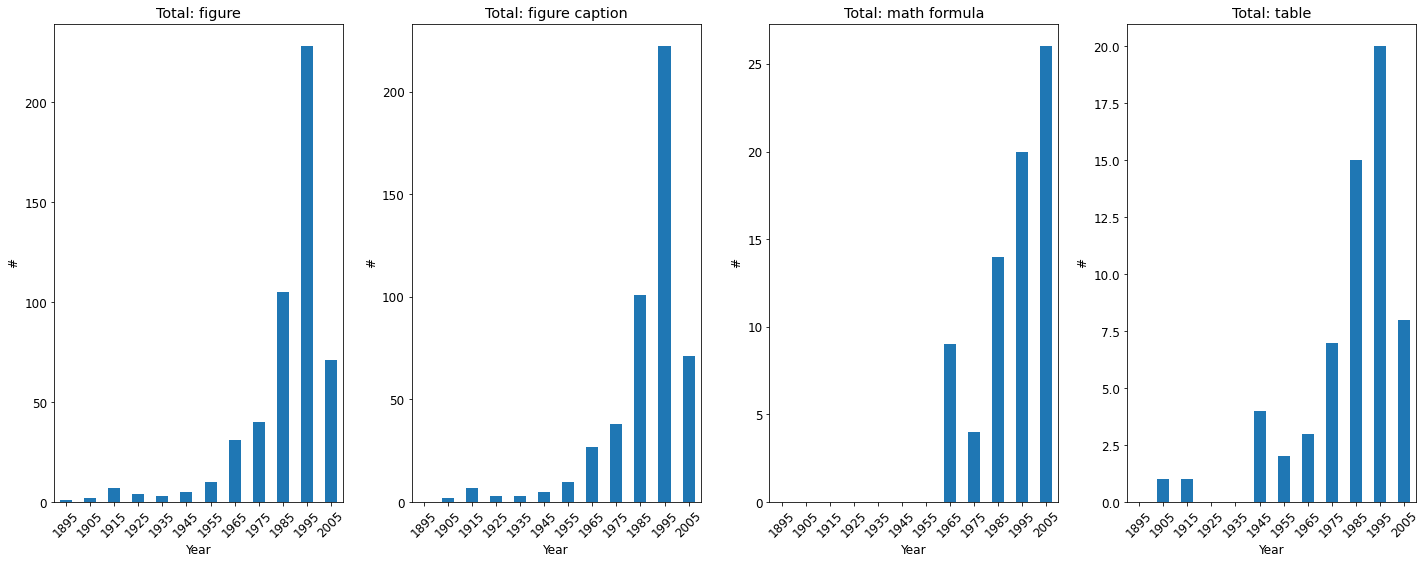

In [21]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

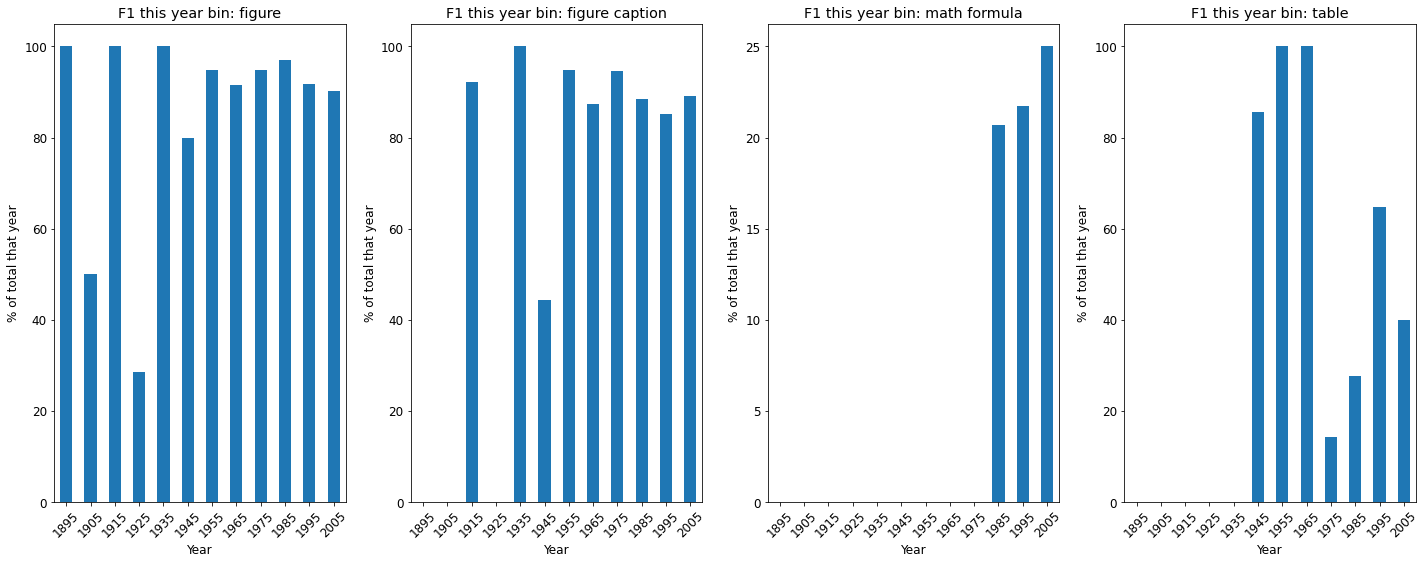

In [22]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Some other metrics:

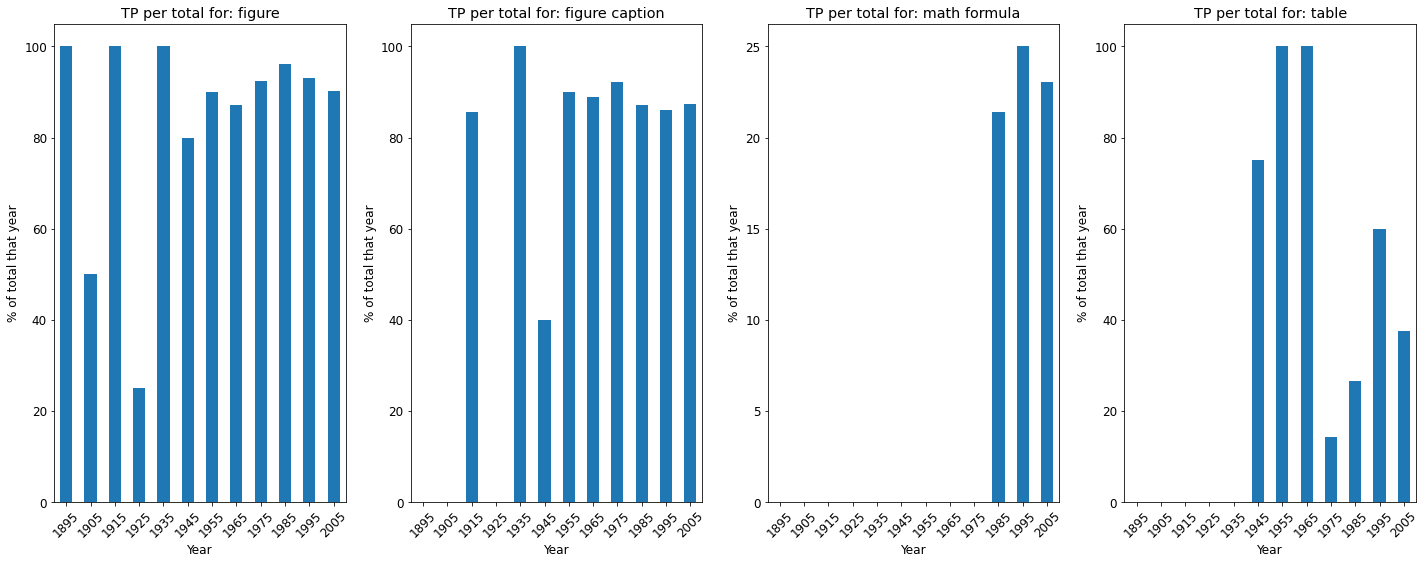

In [23]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

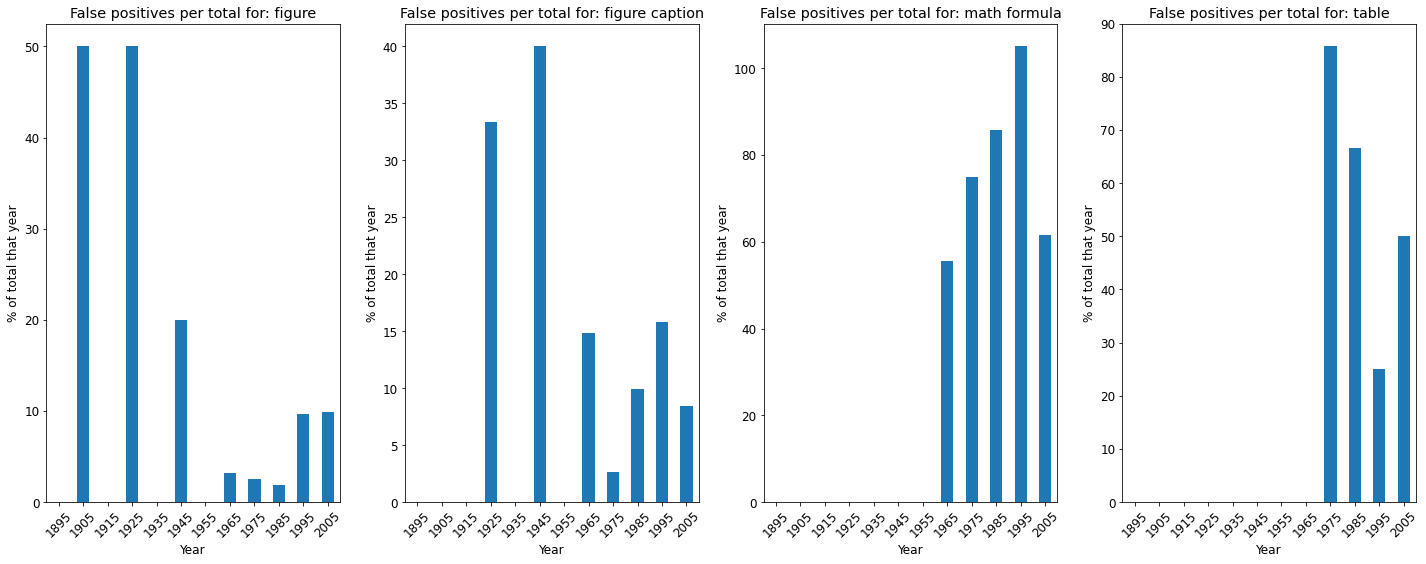

In [24]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

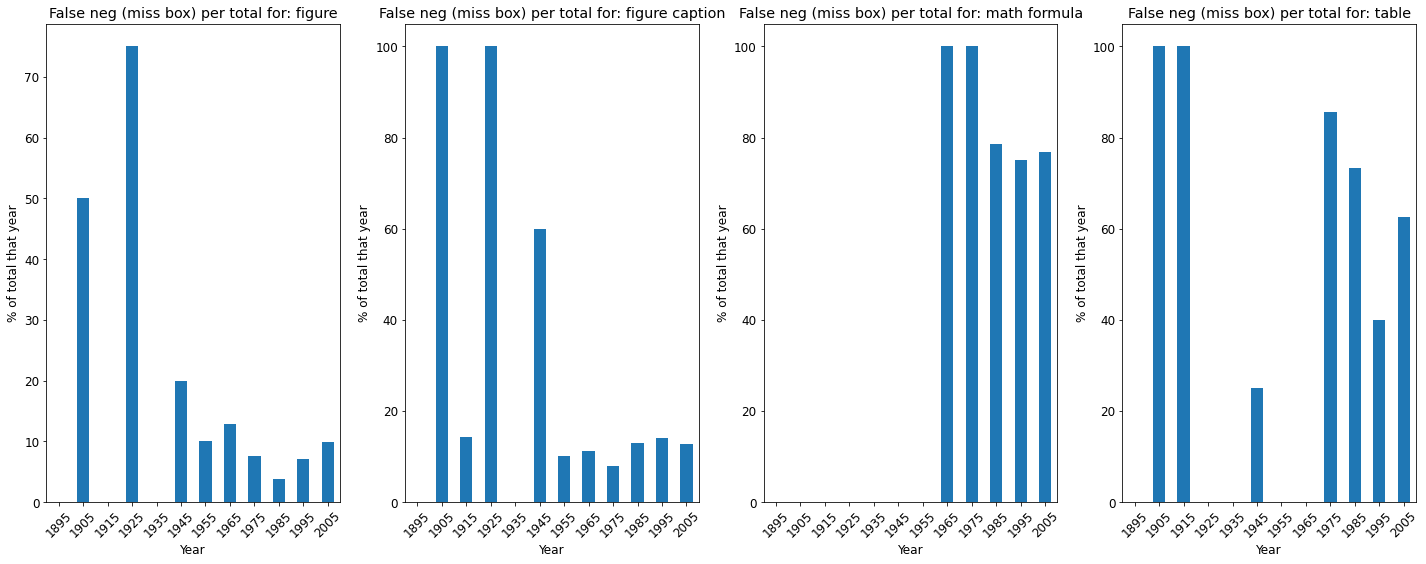

In [25]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

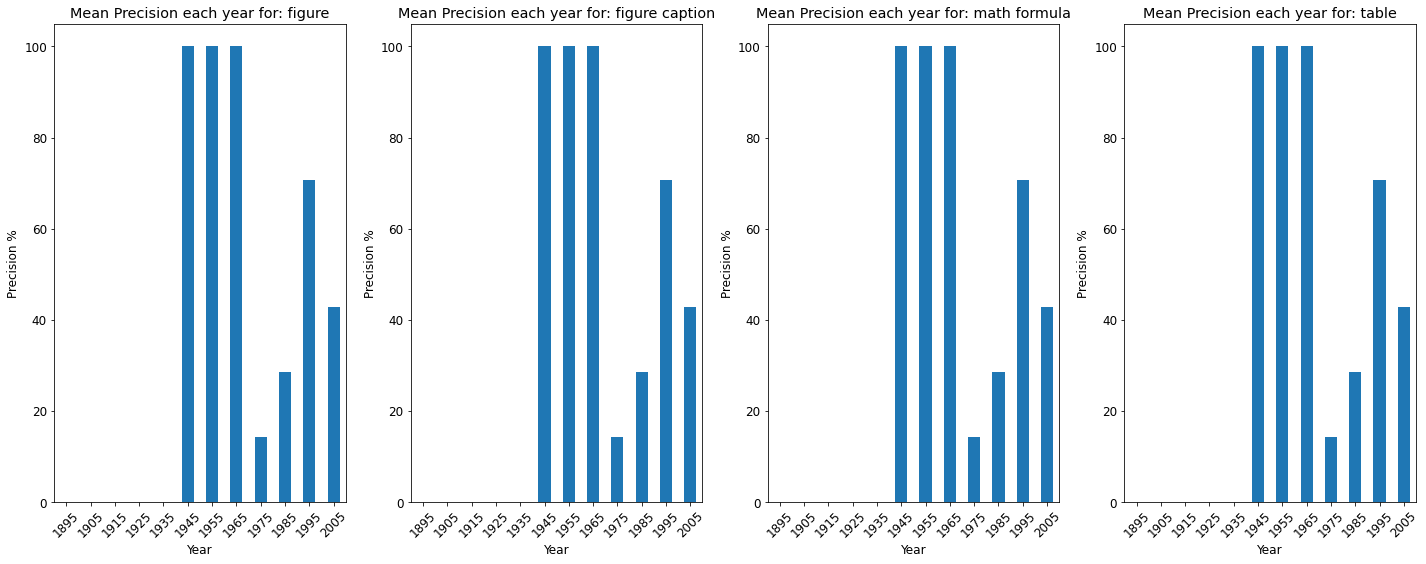

In [26]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

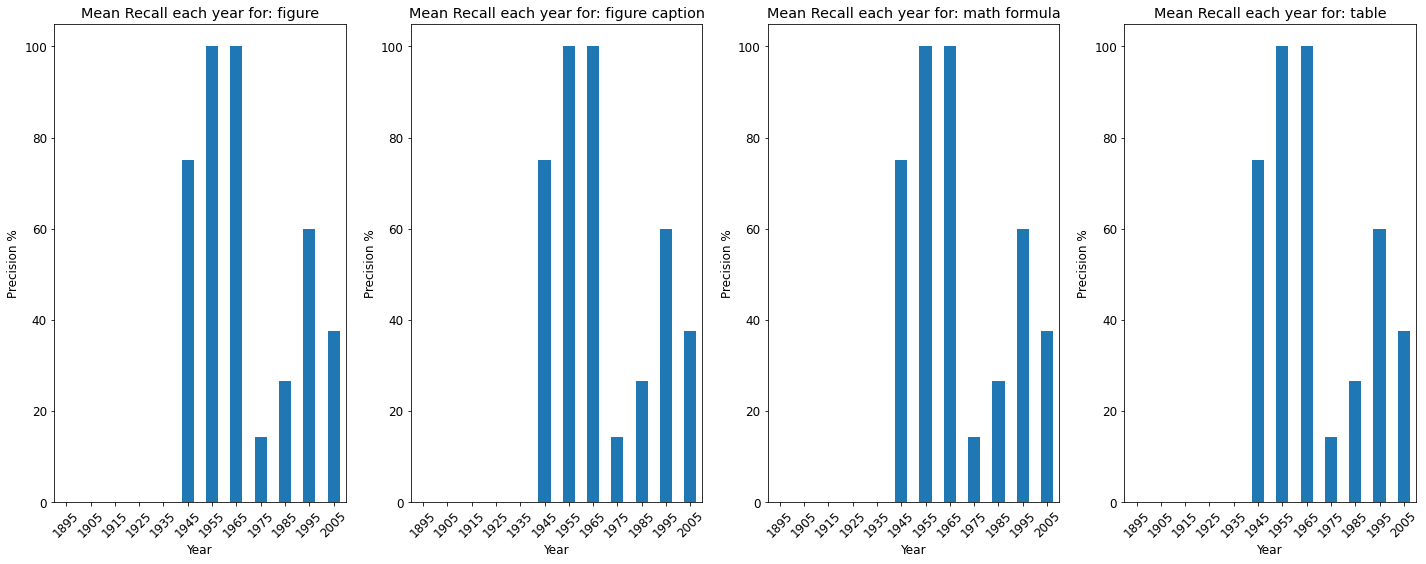

In [27]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

# Other steps of the post processing process

Order of comparisons:

1. Raw true vs raw found (after non-max suppression is applied)
1. If two found boxes overlap with IOU>=0.25, take the one that has the highest score
1. Add in PDF-mining boxes to found boxes.  If caption box overlaps with PDF raw box or a PDF figure caption box, use the PDF-mining box (other things happen with tables that we ignore here).
1. Merge with heuristically-found figure captions.  Take the top of the heuristically-found box and the min/max of the sides and bottom of heuristic box and mega-yolo found box.
1. ~~Add in heuristic-only found captions~~
1. Grow found *and* true figure captions by overlap with OCR-found words and paragraphs.  
   * **does this make wrong trueboxes??**
1. Overlap found figure boxes with image-processing heuristically found boxes -- grow figure boxes by image-processing boxes.
1. Take out super big captions -- captions that are 75% of the area of the page.
1. Match figure captions with figures.  Figures can exist without captions, captions cannot exist without a figure -- if figure caption has no accompanying caption then drop this figure caption. ~~Preference for mega-yolo found captions, if none found, use heuristic-only found captions.~~
1. Expand both true and found figure boxes down to top associated caption boxes (this expands the figure boxes "vertically" down).
1. For both true and found boxes -- if caption box is horizontally larger than the figure box, expand the figure box horizontally to match width of caption box.


## Plot how metrics change with steps

In [28]:
iouvec2 = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]

In [29]:
# order of post-procesings
trueboxes = [truebox, #1
             truebox, #2
             truebox, #3
             truebox, #4
             #truebox, #5
             truebox1, #6
             truebox1, #7
             truebox1, #8
             truebox1, #9
             truebox2, #10
             truebox3] #11
foundboxes = [boxes1,#1
              sboxes_cleaned, #2
              boxes_pdf, #3
              boxes_heur,#4
              #boxes_heur2, #5
              boxes_par_found, 
              boxes_sq1, 
              boxes_sq2, #6 --
              boxes_sq3, #6 --
              boxes_sq4, #7
              boxes_sq5] #8
foundlabels=[labels1, 
             slabels_cleaned,
             labels_pdf,
             labels_heur,
            #labels_heur2,
             labels_par_found,
             labels_sq1,
             labels_sq2,
             labels_sq3,
             labels_sq4,
             labels_sq5]
foundscores=[scores1,
             sscores_cleaned,
             scores_pdf,
             scores_heur,
            #scores_heur2,
             scores_par_found,
             scores_sq1,
             scores_sq2,
             scores_sq3,
             scores_sq4,
             scores_sq5]

In [30]:
len(trueboxes), len(foundboxes), len(foundlabels), len(foundscores)

(10, 10, 10, 10)

In [31]:
precsave = []; recsave = []; f1save = []
TPsave = []; FPsave = []; FNsave = []
ttsave = []

for t,fb,fl,fs in zip(trueboxes, foundboxes, foundlabels, foundscores):
    TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],iouvec2,
                                                  t,fb, fl, fs,n_folds_cv=n_folds_cv,seed=5)
    # combo metrics
    precisions, precision_stds, recalls, \
      recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                                   LABELS,[scoremin],
                                                   iouvec2)

    TPsave.append(TPs[:,0,:].sum(axis=-1)); FPsave.append(FPs[:,0,:].sum(axis=-1)); FNsave.append(FNs[:,0,:].sum(axis=-1))
    ttsave.append(totalTrues[:,:].sum(axis=-1))
    precsave.append(precisions[:,0,:]); recsave.append(recalls[:,0,:]); f1save.append(f1s[:,0,:])
    #import sys; sys.exit()

In [32]:
#labels1
np.array(TPsave).shape, TPs.shape, totalTrues.shape

((10, 4, 18), (4, 1, 18, 5), (4, 5))

In [33]:
n = len(foundboxes)+3
colors = plt.cm.jet(np.linspace(0,1,n))
ylabels = ['TP','FP','FN','Precision', 'Recall', 'F1']

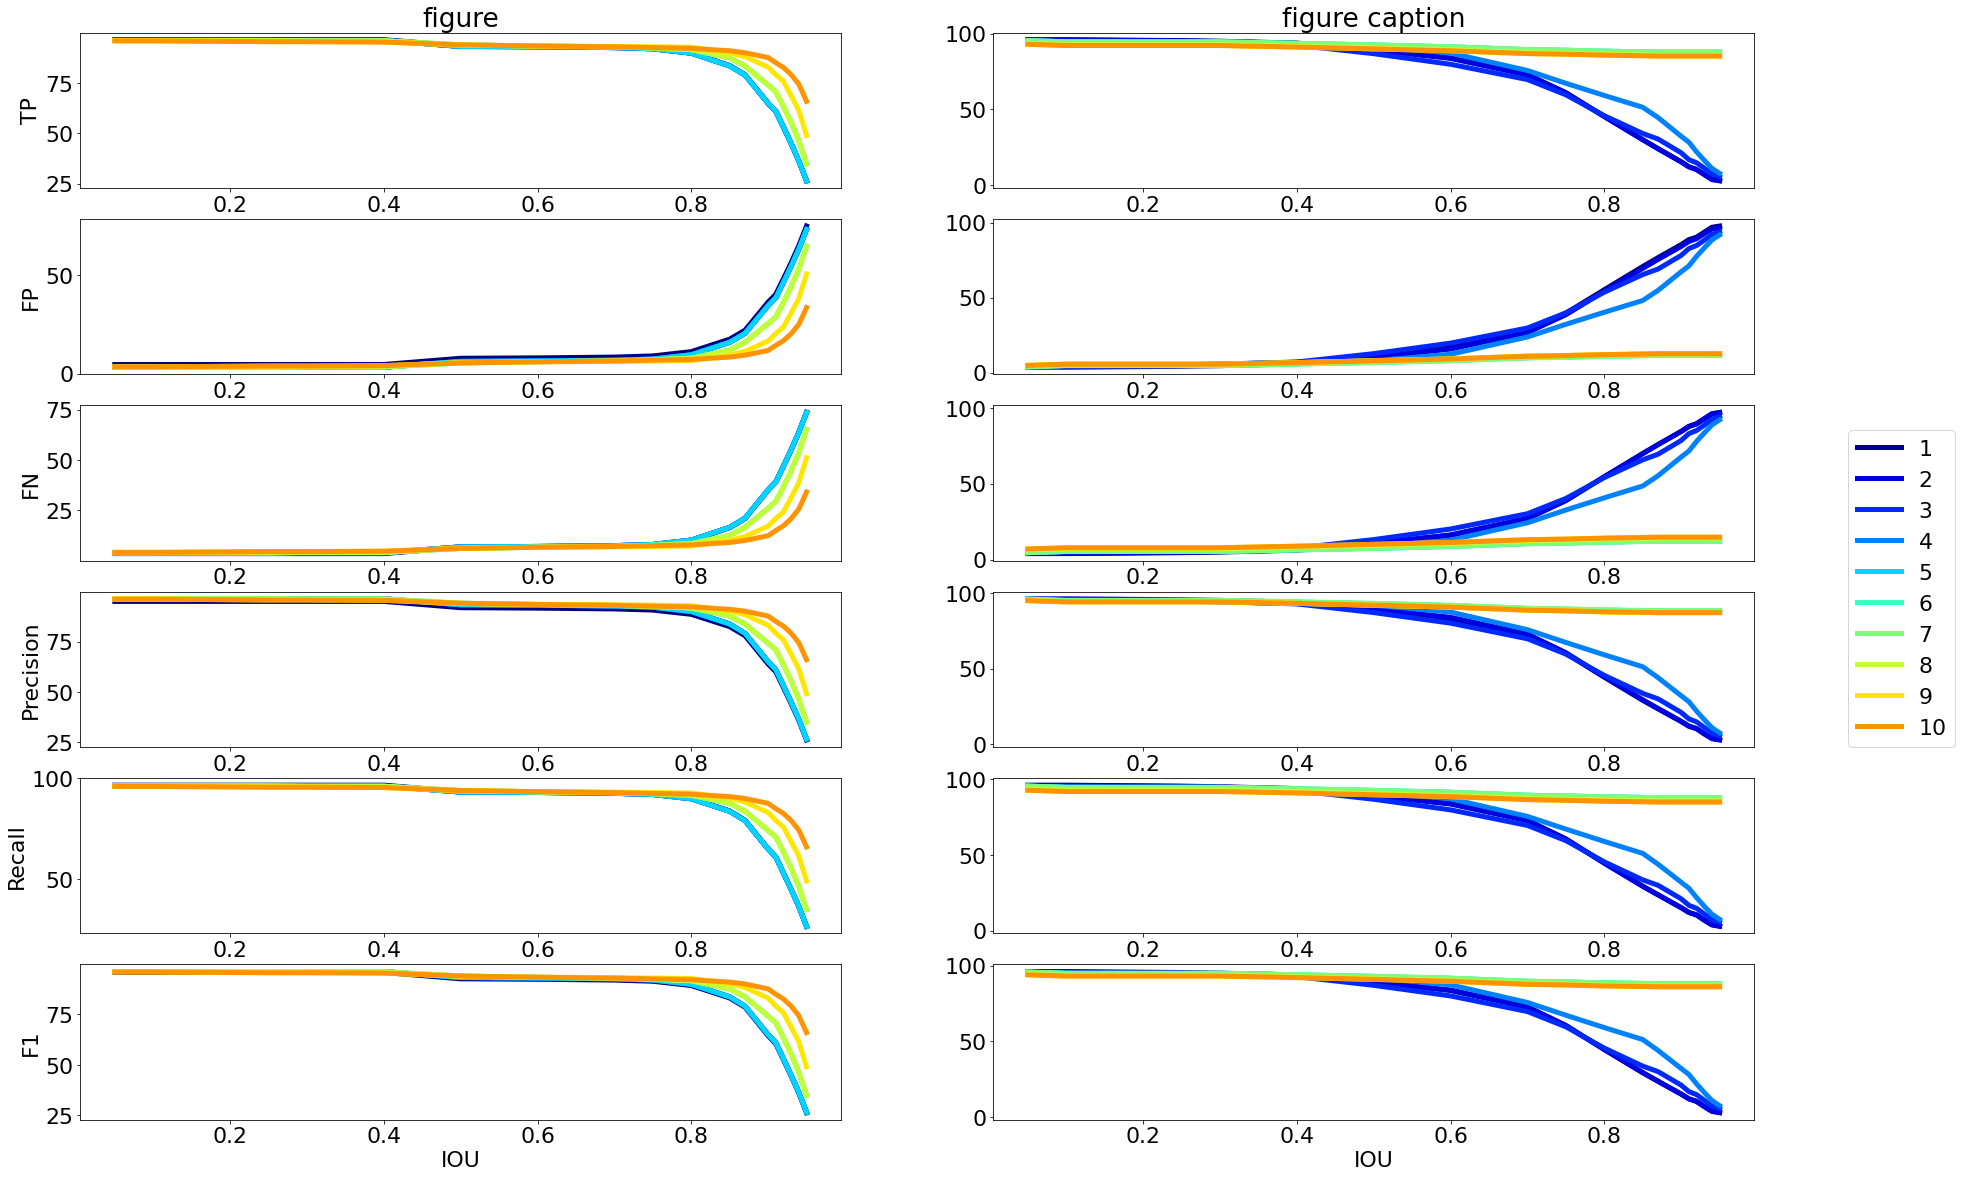

In [34]:
lw=5
# divide by trues?
divide_tt = True
# fontsize?
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
for ip,(p,r,f,tp,fp,fn,tt) in enumerate(zip(precsave,recsave,f1save,TPsave,FPsave,FNsave,ttsave)):
    lwh=lw
    #lwh=5
    #if ip==8: lwh=10
    #lwh = 8-ip
    for il in range(len(LABELS[:2])):
        if not divide_tt:
            ax[0][il].plot(iouvec2, tp[il],color=colors[ip],lw=lwh)
            ax[1][il].plot(iouvec2, fp[il],color=colors[ip],lw=lwh)
            ax[2][il].plot(iouvec2, fn[il],color=colors[ip],lw=lwh)
            if il == 0:
                ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
            else:
                ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
            ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
            ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
        else:
            ax[0][il].plot(iouvec2, tp[il]/tt[il]*100,color=colors[ip],lw=lwh)
            ax[1][il].plot(iouvec2, fp[il]/tt[il]*100,color=colors[ip],lw=lwh)
            ax[2][il].plot(iouvec2, fn[il]/tt[il]*100,color=colors[ip],lw=lwh)
            if il == 0:
                ax[3][il].plot(iouvec2, p[il],color=colors[ip],label=str(ip+1),lw=lwh)
            else:
                ax[3][il].plot(iouvec2, p[il],color=colors[ip],lw=lwh)
            ax[4][il].plot(iouvec2, r[il],color=colors[ip],lw=lwh)
            ax[5][il].plot(iouvec2, f[il],color=colors[ip],lw=lwh)
        
for k in range(6): 
    ax[k][0].set_ylabel(ylabels[k])
    #for j in range(len(LABELS[:2])):
    #    ax[k][j].set_yscale('log')
    
ax[0][0].set_title('figure')
ax[0][1].set_title('figure caption')
ax[5][0].set_xlabel('IOU')
ax[5][1].set_xlabel('IOU')

fig.legend(loc='center right')
plt.show()

If you're building up different post-processing steps, check out the ratio of the last two.

Negative = drop, positive = increase

In [35]:
# # plot ratio of last 2 changes
# fig, ax = plt.subplots(6,len(LABELS[:2]),figsize=(30,20))
# lwh=5
# for il in range(len(LABELS[:2])):
#     ax[0][il].plot(iouvec2, TPsave[-1][il]/TPsave[-2][il]-1,color=colors[ip],lw=lwh)
#     ax[1][il].plot(iouvec2, FPsave[-1][il]/FPsave[-2][il]-1,color=colors[ip],lw=lwh)
#     ax[2][il].plot(iouvec2, FNsave[-1][il]/FNsave[-2][il]-1,color=colors[ip],lw=lwh)
#     ax[3][il].plot(iouvec2, precsave[-1][il]/precsave[-2][il]-1,color=colors[ip],lw=lwh)
#     ax[4][il].plot(iouvec2, recsave[-1][il]/recsave[-2][il]-1,color=colors[ip],lw=lwh)
#     ax[5][il].plot(iouvec2, f1save[-1][il]/f1save[-2][il]-1,color=colors[ip],lw=lwh)
        
# for k in range(6): 
#     ax[k][0].set_ylabel(ylabels[k])
#     #for j in range(len(LABELS[:2])):
#     #    ax[k][j].set_yscale('log')
# ax[0][0].set_title('figure')
# ax[0][1].set_title('figure caption')

# plt.show()

## Save to .dat files if requested

In [36]:
import os

In [37]:
if save_dats:
    # save too
    out_num_name = binary_dirs.split('/')[0]+adder_dats
    num_out_file = config.save_table_dats_dir + out_num_name
    #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
    #if out_num_name != 'main':
    if not os.path.exists(num_out_file+'/'):
        os.makedirs(num_out_file+'/')
    ioumin_per_labels = ioustar # just the one for our decisions
    num_out_file += '/' + out_num_name
    # how many labels to save up to?
    lend = 2

    # save to file
    with open(num_out_file + '_score.dat','w') as fnum:
        print(scorestar, file=fnum, end='')
    with open(num_out_file + '_ncv.dat','w') as fnum:
        print(n_folds_cv, file=fnum, end='')


    TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
                                                  truebox3,boxes_sq5,labels_sq5, 
                                                  scores_sq5,n_folds_cv=n_folds_cv)

    precision, precision_std, recall, \
      recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                                   LABELS,[scorestar],
                                                   ioustar)


    # print out total true
    for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
        with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
            print(int(m), file=fnum, end='')

    # print out TP
    for ii,iou in enumerate(ioustar):
        iouhere = str(iou).replace('.','p')

        TP = TPv[:,0,ii,:].sum(axis=-1)
        FP = FPv[:,0,ii,:].sum(axis=-1)
        FN = FNv[:,0,ii,:].sum(axis=-1)

        for il,m in enumerate(TP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FP[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(FN[:lend]):
            dat = str(round(m/totalTrue[il]*100,1))
            with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
            with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
            with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')

        for il,m in enumerate(LABELS[:lend]):
            dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
            with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
                print(dat, file=fnum, end='')


In [38]:
binary_dirs

'binaries_model6_tfrecordz/'